Kita bekerja di agensi travel yang memiliki beberapa cabang di kota-kota yang ada di pulau Jawa. Perusahaan kita bertanggung jawab membantu klien mengunjungi destinasi wisata di Pulau Jawa sesuai keinginannya.

**Permasalahan**
* Bagaimana karakteristik wisatawan?
* Adanya asumsi bahwa bogor merupakan kota destinasi yang paling favorit karena selalu macet total ketika memasuki waktu liburan
* Adanya asumsi bahwa jumlah orang yang memberikan rating bisa mempengaruhi nilai rating itu sendiri, karena semakin sedikit orang yang memberikan rating akan membuat rating itu tampak tinggi.
* Tim Customer Specialist merasa kesusahan memfilter data tempat wisata berdasarkan rating dan kategori. Butuh pemrosesan khusus untuk menggambungkan rating yang merupakan data numerikal dan kategori yang merupakan data kategorikal.


**Tujuan**
* Mengetahui karakteristik wisatawan
* Menguji kebenaran asumsi bahwa bogor merupakan kota destinasi yang paling favorit
* Menguji kebenaran asumsi bahwa semakin banyak orang yang memberi rating semakin rendah nilai rating
*  Membuat sistem rekomendasi tempat wisata di Yogyakarta sehingga Tim Customer Specialist mudah merekomendasikan tempat tempat yang serupa jika terjadi penolakan dalam penyusunan itinerary perjalanan wisata ke Yogyakarta.



## Menyiapkan library yang dibutuhkan

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import pickle
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors

## Data Collection

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
user_df = pd.read_csv("/content/drive/MyDrive/Indonesia Tourism Destination/user.csv")
tourism_df = pd.read_csv("/content/drive/MyDrive/Indonesia Tourism Destination/tourism_with_id.csv")
rating_df = pd.read_csv("/content/drive/MyDrive/Indonesia Tourism Destination/tourism_rating.csv")

## Data Understanding

Terdapat 3 data dari Tim Sales marketing untuk kita olah dan kita analisis, diantaranya data klien (user.csv), tempat wisata yang dikunjungi klien (tourism_with_id.csv), dan nilai kesukaan klien terhadap tempat wisata yang telah dikunjungi (tourism_rating.csv).

In [4]:
user_df.head(3)

,User_Id,Location,Age
0,1,"Semarang, Jawa Tengah",20
1,2,"Bekasi, Jawa Barat",21
2,3,"Cirebon, Jawa Barat",23


Deskripsi setiap kolom pada dataset user:

*   User_Id → No id pengunjung
*   Location → kota dan provinsi asal pengunjung
*   Age → umur pengunjung

In [5]:
tourism_df.head(3)

,Place_Id,Place_Name,Description,Category,City,Price,Rating,Time_Minutes,Coordinate,Lat,Long,Unnamed: 11,Unnamed: 12
0,1,Monumen Nasional,Monumen Nasional atau yang populer disingkat d...,Budaya,Jakarta,20000,4.6,15.0,"{'lat': -6.1753924, 'lng': 106.8271528}",-6.175392,106.827153,NaN,1
1,2,Kota Tua,"Kota tua di Jakarta, yang juga bernama Kota Tu...",Budaya,Jakarta,0,4.6,90.0,"{'lat': -6.137644799999999, 'lng': 106.8171245}",-6.137645,106.817125,NaN,2
2,3,Dunia Fantasi,Dunia Fantasi atau disebut juga Dufan adalah t...,Taman Hiburan,Jakarta,270000,4.6,360.0,"{'lat': -6.125312399999999, 'lng': 106.8335377}",-6.125312,106.833538,NaN,3


Deskripsi setiap kolom pada dataset Tourism:
* Place_Id → No id tempat wisata
* Place_Name → Nama tempat wisata
* Description → Deskripsi tempat wisata
* Category → Jenis Wisata
* City → Kota tempat wisata berada
* Price → harga tempat wisata
* Rating → Rating tempat wisata
* Time_Minutes: Durasi perjalanan yang ditempuh dari pusat kota
* Coordinate → titik koordinat tempat wisata
* Lat	 → Latitude tempat wisata
* Long → Longitude tempat wisata
* Unnamed: 11 → (kolom kosong)
* Unnamed: 12 → (tidak ada keterangan)



In [6]:
# mengecek asumsi bahwa kolom Unnamed: 12 duplicate dengan Place_id
tourism_df[["Place_Id", "Unnamed: 12"]]

,Place_Id,Unnamed: 12
0,1,1
1,2,2
2,3,3
3,4,4
4,5,5
...,...,...
432,433,433
433,434,434
434,435,435
435,436,436


In [7]:
rating_df.head(3)

,User_Id,Place_Id,Place_Ratings
0,1,179,3
1,1,344,2
2,1,5,5


Deskripsi setiap kolom pada dataset rating:
*   User_Id → ID tempat pengunjung
*   Place_Id → ID Tempat wisata
*   Place_Ratings → Rating tempat wisata

## Data Accessing

In [8]:
user_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   User_Id   300 non-null    int64 
 1   Location  300 non-null    object
 2   Age       300 non-null    int64 
dtypes: int64(2), object(1)
memory usage: 7.2+ KB


In [9]:
tourism_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 437 entries, 0 to 436
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Place_Id      437 non-null    int64  
 1   Place_Name    437 non-null    object 
 2   Description   437 non-null    object 
 3   Category      437 non-null    object 
 4   City          437 non-null    object 
 5   Price         437 non-null    int64  
 6   Rating        437 non-null    float64
 7   Time_Minutes  205 non-null    float64
 8   Coordinate    437 non-null    object 
 9   Lat           437 non-null    float64
 10  Long          437 non-null    float64
 11  Unnamed: 11   0 non-null      float64
 12  Unnamed: 12   437 non-null    int64  
dtypes: float64(5), int64(3), object(5)
memory usage: 44.5+ KB


In [10]:
rating_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   User_Id        10000 non-null  int64
 1   Place_Id       10000 non-null  int64
 2   Place_Ratings  10000 non-null  int64
dtypes: int64(3)
memory usage: 234.5 KB


Data Overview Summary
*  Time_Minutes pada tourism_df sebagian nilai kosong
*  Unnamed: 11 pada tourism_df seluruhnya memiliki nilai kosong
*  Unnamed: 12 pada tourism_df memiliki nilai yang sama dengan Place_id
*  Location pada user_df berisikan Kota dan Provinsi sedangkan data pada tourism_df hanya berisikan kota
*   Unnamed: 12 pada tourism_df memiliki nilai yang sama dengan Place_id
*   Terdapat perbedaan penulisan kota "Jakarta" pada user_df dan tourism_df








## Data Cleaning

### mengisi nilai null

In [11]:
print("Jumlah baris yang kosong di Time_Minutes: ",
      tourism_df['Time_Minutes'].isna().sum())

# mencari nilai median dari kolom Time_Minutes
median_time = tourism_df['Time_Minutes'].median()

# mengisi nilai yang kosong di Time_Minutes dengan nilai modus
tourism_df['Time_Minutes'].fillna(median_time, inplace=True)

#mengetahui baris yang kosong ada berapa
print("Jumlah baris yang kosong di Time_Minutes: ",
      tourism_df['Time_Minutes'].isna().sum())

Jumlah baris yang kosong di Time_Minutes:  232
Jumlah baris yang kosong di Time_Minutes:  0


### menghapus kolom

In [12]:
# mengetahui jumlah kolom sebelum dihapus
print("ukuran sebelum menghapus kolom: ", tourism_df.shape)

# menghapus kolom yang ada
tourism_df = tourism_df.drop(["Coordinate", "Unnamed: 11", "Unnamed: 12", "Description"], axis = 1)

# mengetahui jumlah kolom sesudah dihapus
print("ukuran serelah menghapus kolom: ", tourism_df.shape)

ukuran sebelum menghapus kolom:  (437, 13)
ukuran serelah menghapus kolom:  (437, 9)


Alasan Penghapusan:
*   Unnamed: 11 pada tourism_df seluruhnya memiliki nilai kosong
*   Unnamed: 12 pada tourism_df memiliki nilai yang sama dengan Place_id
*   Coordinate dan Description tidak diperlukan





### Penyederhanaan Data

Location pada user_df berisikan Kota dan Provinsi sedangkan data pada tourism_df hanya berisikan Kota. Sehingga perlu dilakukan penyederhanaan data untuk kebutuhan analisis kemudian

In [13]:
# untuk menampilkan hasil sebelum disederhanakan
print("Location sebelum disederhanakan:", user_df['Location'].head(2))

# pengambilan nama kota dengan pemisah koma
splitted_city = lambda x: x.split(",")[0]

# merubah isi nilai "Kota, Provinsi" menjadi "Kota" di kolom Location
user_df["Location"] = user_df["Location"].apply(splitted_city)

# untuk menampilkan hasil setelah disederhanakan
print("Location sebelum disederhanakan:", user_df['Location'].head(2))

Location sebelum disederhanakan: 0    Semarang, Jawa Tengah
1       Bekasi, Jawa Barat
Name: Location, dtype: object
Location sebelum disederhanakan: 0    Semarang
1      Bekasi
Name: Location, dtype: object


Terdapat perbedaan penulisan kota "Jakarta" pada user_df dan tourism_df yang perlu disamakan untuk mempermudah proses analisis

In [14]:
print("Jumlah nilai yang sama di kolom Location: ", user_df["Location"].nunique())

# membuat fungsi untuk mengubah nilai 'Jakarta Selatan', 'Jakarta Utara' menjadi nilai Jakarta
def convert_city(x):
  if 'Jakarta' in x:
    return 'Jakarta'
  else:
    return x

# menerapkan fungsi yang telah dibuat untuk kolom Location
user_df["Location"] = user_df["Location"].apply(lambda x: convert_city(x))

print("Jumlah nilai yang sama di kolom Location: ", user_df["Location"].nunique())

Jumlah nilai yang sama di kolom Location:  28
Jumlah nilai yang sama di kolom Location:  24


Jumlah orang yang memberikan rating bisa mempengaruhi nilai rating itu sendiri, karena semakin sedikit orang yang memberikan rating akan membuat rating itu tampak tinggi. Sehingga kita perlu membuat kolom 'Rating_Count' untuk menampung nilai banyaknya orang yang memberikan rating pada tempat tersebut.

In [15]:
print("ukuran sebelum menambah kolom: ", tourism_df.shape)

# membuat fungsi untuk mencari banyaknya tempat tersebut diberi rating
def get_frequency(x, value_counts):
  if x in value_counts:
    return value_counts[x]
  else:
    return 0

# menghitung banyaknya nilai Place Id yang muncul di tourism_df
value_counts = rating_df["Place_Id"].value_counts()

# menambah kolom baru dengan nama 'Rating_Count'
tourism_df["RatingCount"] = tourism_df["Place_Id"].apply(lambda x: get_frequency(x, value_counts))

print("ukuran sebelum menambah kolom: ", tourism_df.shape)

ukuran sebelum menambah kolom:  (437, 9)
ukuran sebelum menambah kolom:  (437, 10)


In [16]:
tourism_df.head()

,Place_Id,Place_Name,Category,City,Price,Rating,Time_Minutes,Lat,Long,RatingCount
0,1,Monumen Nasional,Budaya,Jakarta,20000,4.6,15.0,-6.175392,106.827153,18
1,2,Kota Tua,Budaya,Jakarta,0,4.6,90.0,-6.137645,106.817125,25
2,3,Dunia Fantasi,Taman Hiburan,Jakarta,270000,4.6,360.0,-6.125312,106.833538,19
3,4,Taman Mini Indonesia Indah (TMII),Taman Hiburan,Jakarta,10000,4.5,60.0,-6.302446,106.895156,21
4,5,Atlantis Water Adventure,Taman Hiburan,Jakarta,94000,4.5,60.0,-6.124190,106.839134,25


In [17]:
tourism_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 437 entries, 0 to 436
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Place_Id      437 non-null    int64  
 1   Place_Name    437 non-null    object 
 2   Category      437 non-null    object 
 3   City          437 non-null    object 
 4   Price         437 non-null    int64  
 5   Rating        437 non-null    float64
 6   Time_Minutes  437 non-null    float64
 7   Lat           437 non-null    float64
 8   Long          437 non-null    float64
 9   RatingCount   437 non-null    int64  
dtypes: float64(4), int64(3), object(3)
memory usage: 34.3+ KB


In [18]:
user_df.to_csv("/content/drive/MyDrive/Indonesia Tourism Destination/clean_users.csv", index=False, sep=';')
tourism_df.to_csv("/content/drive/MyDrive/Indonesia Tourism Destination/clean_tourisms.csv", index=False, sep=';')

In [19]:
# kolom user_df setelah dilakukan cleaning
user_df.head()

,User_Id,Location,Age
0,1,Semarang,20
1,2,Bekasi,21
2,3,Cirebon,23
3,4,Bekasi,21
4,5,Lampung,20


In [20]:
# kolom tourism_df setelah dilakukan cleaning
tourism_df.head()

,Place_Id,Place_Name,Category,City,Price,Rating,Time_Minutes,Lat,Long,RatingCount
0,1,Monumen Nasional,Budaya,Jakarta,20000,4.6,15.0,-6.175392,106.827153,18
1,2,Kota Tua,Budaya,Jakarta,0,4.6,90.0,-6.137645,106.817125,25
2,3,Dunia Fantasi,Taman Hiburan,Jakarta,270000,4.6,360.0,-6.125312,106.833538,19
3,4,Taman Mini Indonesia Indah (TMII),Taman Hiburan,Jakarta,10000,4.5,60.0,-6.302446,106.895156,21
4,5,Atlantis Water Adventure,Taman Hiburan,Jakarta,94000,4.5,60.0,-6.124190,106.839134,25


## Exploratory Data Analysis Univariate

### Memahami Karakteristik Wisatawan

 memahami asal kota dan umur dari klien yang terdaftar di agensi travel kita.

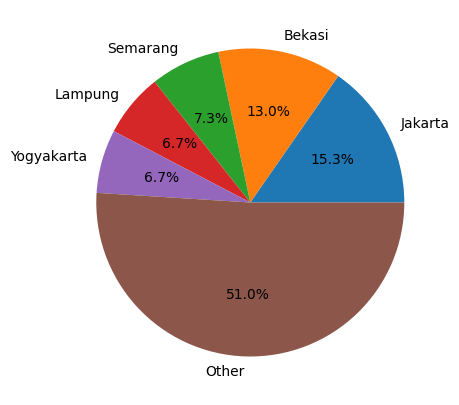

In [21]:
# menghitung banyaknya wisatawan dari setiap kota
user_loc = user_df["Location"].value_counts()

# mengambil 5 kota asal dari wisatawan yang terbanyak
top_user_loc = user_loc.sort_values(ascending = False)[:5]

# menyederhanakan kota lain sebagai other
top_user_loc["Other"] = user_loc.sort_values(ascending=False)[5:].sum()

# pembuatan pie chart
plt.figure(figsize=(10,5))
plt.pie(top_user_loc, labels=top_user_loc.index, autopct = '%1.1f%%')
plt.show()

Berdasarkan Pie chart diatas terlihat bahwa klien agensi travel kita kebanyakan berasal dari Kota Jakarta dengan persentase 15.3% dan Bekasi dengan persentase 13% dibandingkan kota lainnya.

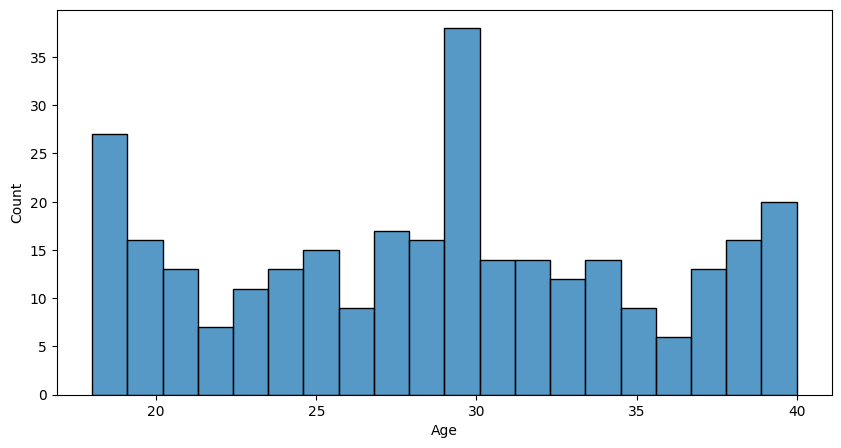

In [22]:
plt.figure(figsize = (10, 5))

#Membuat hitogram untuk melihat distribusi persebaran umur wisatawan
sns.histplot(x=user_df['Age'], bins=20)

# Menampilkan histogram yang telah dirancang
plt.show()

Dari histogram diatas, dapat diketahui bahwa umur dari klien agensi kita berada pada rentang 6 tahun - 40 tahun dengan yang tertinggi berada di umur 30 tahunan. Lalu yang tertinggi kedua adalah umur klien agensi kita yang kurang dari 10 tahun. Hal ini bisa terjadi karena klien agensi kita yang berumur 30 tahunan selalu membawa anak-anak mereka selama berwisata.

## Memahami karakteristik objek wisata

Sesuai dengan tujuan yang didefinisikan diatas, perlu menguji kebenaran asumsi bahwa bogor merupakan kota destinasi yang paling favorit.

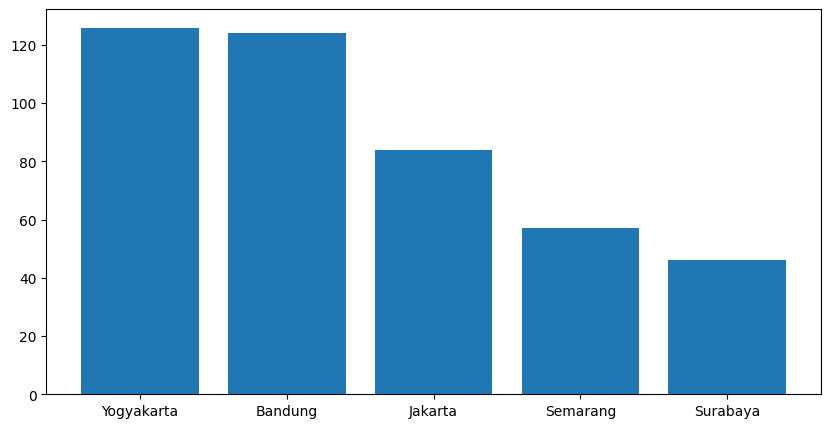

In [23]:
# Menghitung banyak kota yang dikunjungi oleh klien agensi kita
city_counts = tourism_df["City"].value_counts()

# Membuat bar chart mengenai kota yang paling banyak dikunjungi
plt.figure(figsize = (10,5))
plt.bar(city_counts.index,city_counts)
plt.show()

Dari bar chart diatas terlihat bahwa objek wisata terbanyak berada di Yogyakarta dan Bandung, sehingga dapat diketahui bahwa asumsi tidak benar jika Bogor adalah kota yang paling disukai oleh klien agensi kita.

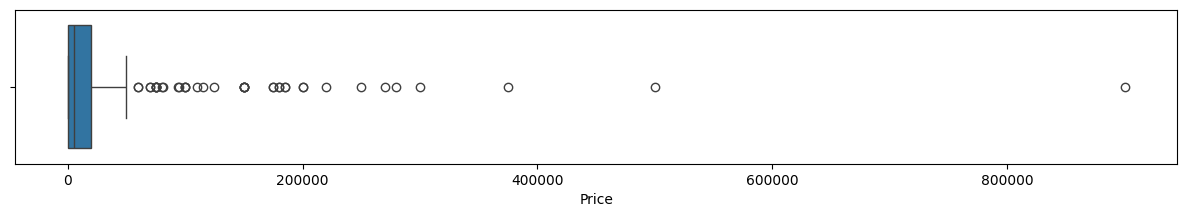

In [24]:
#Membuat boxplot untuk melihat distribusi persebaran price objek wisata
plt.figure(figsize = (15,2))
sns.boxplot(x=tourism_df["Price"])
plt.show()

In [25]:
# mengurutkan dataset dari price yang paling tinggi
tourism_df.sort_values(by='Price', ascending=False)

,Place_Id,Place_Name,Category,City,Price,Rating,Time_Minutes,Lat,Long,RatingCount
13,14,Pulau Pelangi,Bahari,Jakarta,900000,4.8,60.0,-5.587055,106.588500,18
143,144,Goa Jomblang,Cagar Alam,Yogyakarta,500000,4.6,60.0,-8.028156,110.638331,21
296,297,Mountain View Golf Club,Cagar Alam,Bandung,375000,4.4,120.0,-6.862938,107.648219,27
71,72,Waterboom PIK (Pantai Indah Kapuk),Taman Hiburan,Jakarta,300000,4.4,60.0,-6.113656,106.747860,13
213,214,Trans Studio Bandung,Taman Hiburan,Bandung,280000,4.5,240.0,-6.925094,107.636494,18
...,...,...,...,...,...,...,...,...,...,...
57,58,Taman Ayodya,Taman Hiburan,Jakarta,0,4.4,45.0,-6.245229,106.794665,16
309,310,Taman Bunga Cihideung,Cagar Alam,Bandung,0,4.1,45.0,-6.803888,107.586631,21
56,57,Taman Lapangan Banteng,Taman Hiburan,Jakarta,0,4.7,60.0,-6.170555,106.835038,14
313,314,Tafso Barn,Cagar Alam,Bandung,0,4.2,180.0,-6.842645,107.622841,24


In [26]:
tourism_df["Price"].describe()

count       437.000000
mean      24652.173913
std       66446.374709
min           0.000000
25%           0.000000
50%        5000.000000
75%       20000.000000
max      900000.000000
Name: Price, dtype: float64

*   mean : Rata-rata harga tempat wisata 24,652
*   std : Standar deviasi harga tempat wisata satu dengan lainnya sekitar 66,446
*   min : harga tempat wisata minimum adalah 0 atau gratis
*   25% : 25% dari harga tempat wisata memiliki price 0 atau gratis
*   50% : 50% dari tempat wisata memiliki harga sebesar 5,000
*   75% : 75% dari tempat wisata memiliki harga sebesar 20,000
*   max : pendapatan maksimum dari suatu tempat wisata adalah 900,000









Dari pengecekan diatas terlihat bahwa price terjauh  adalah Pulau Pelangi. Adapun hal ini dapat dikatakan sebagai suatu angka yang normal mengingat adanya kemungkinan tempat wisata yang menggunakan boat

Berdasasarkan box plot dan statistik deskriptif diatas dapat diketahui bahwa kunjungan wisata yang disediakan agensi travel kita kebanyakan berkisar pada harga Rp 0 - Rp 5.000

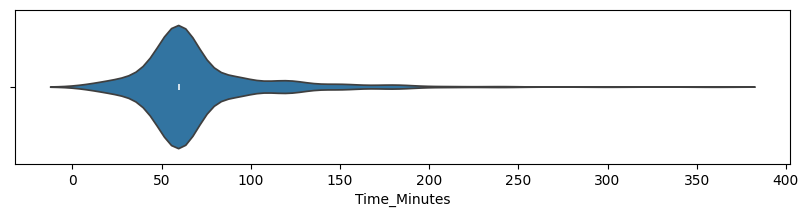

In [27]:
# Membuat violin plot untuk melihat distribusi dari kolom 'Time_Minutes' di tourism_df
plt.figure(figsize=(10,2))
sns.violinplot(x=tourism_df["Time_Minutes"])
plt.show()

In [28]:
tourism_df['Time_Minutes'].describe()

count    437.000000
mean      70.606407
std       37.889092
min       10.000000
25%       60.000000
50%       60.000000
75%       60.000000
max      360.000000
Name: Time_Minutes, dtype: float64

Berdasarkan visualisasi data dalam violin plot dan statistik  deskriptif dari kolom Time Minutes di tourism_df, dapat diketahui bahwa banyak tempat wisata yang disediakan oleh agensi travel kita yang membutuhkan waktu 60 menit untuk menempuhnya dari pusat kota.

## Exploratory Data Analysis Multivariate

ketiga data digabungkan menjadi satu dataframe agar dapat melakukan seluruh variabel dengan satu dataframe

In [29]:
user_ratings = pd.merge(user_df, rating_df, how="left", on=["User_Id"])
user_ratings.head()

,User_Id,Location,Age,Place_Id,Place_Ratings
0,1,Semarang,20,179,3
1,1,Semarang,20,344,2
2,1,Semarang,20,5,5
3,1,Semarang,20,373,3
4,1,Semarang,20,101,4


In [30]:
# penggabungan data user rating dengan data detail tempat wisatauntuk mengetahui lokasi dan kategori tempat wisata yang di rating oleh user
user_rating_details = pd.merge(user_ratings, tourism_df, how='left', on=["Place_Id"])
user_rating_details.head()

,User_Id,Location,Age,Place_Id,Place_Ratings,Place_Name,Category,City,Price,Rating,Time_Minutes,Lat,Long,RatingCount
0,1,Semarang,20,179,3,Candi Ratu Boko,Budaya,Yogyakarta,75000,4.6,90.0,-7.770542,110.489416,24
1,1,Semarang,20,344,2,Pantai Marina,Bahari,Semarang,3000,4.1,60.0,-6.948877,110.389329,33
2,1,Semarang,20,5,5,Atlantis Water Adventure,Taman Hiburan,Jakarta,94000,4.5,60.0,-6.124190,106.839134,25
3,1,Semarang,20,373,3,Museum Kereta Ambarawa,Budaya,Semarang,10000,4.5,60.0,-7.264599,110.404602,28
4,1,Semarang,20,101,4,Kampung Wisata Sosro Menduran,Budaya,Yogyakarta,0,4.0,60.0,-7.792190,110.362151,24


melalui Exploratory Data Analysis Multivariate akan dilihat bagaimana Variabel Independent (Variabel yang mempengaruhi variabel target) mempengaruhi Variabel Dependent (Variabel target)

Variabel Independent:
*   Age
*   Location
*   Category
*   City
*   Price
*   Time_Minutes
*   Lat
*   Long

Variabel Dependent:
*   Place_Ratings











In [31]:
# membuat heatmaps untuk melihat korelasi antara variable Rating dan RatingCount
corr = tourism_df.drop(["Place_Id", "Lat", "Long"], axis=1).corr()
corr

<ipython-input-31-b2d2d8dbc8b5>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = tourism_df.drop(["Place_Id", "Lat", "Long"], axis=1).corr()


,Price,Rating,Time_Minutes,RatingCount
Price,1.000000,0.023243,0.222166,-0.066058
Rating,0.023243,1.000000,0.007302,0.066040
Time_Minutes,0.222166,0.007302,1.000000,0.021639
RatingCount,-0.066058,0.066040,0.021639,1.000000


In [32]:
px.imshow(corr, text_auto=True)

*   Angka korelasi antara Rating dan RatingCount menunjukkan korelasi positif yang lemah antara keduanya. Artinya semakin tinggi jumlah rating suatu tempat wisata dengan kemungkinan yang rendah rating yang diperoleh juga akan naik



## Kesimpulan
1.   Klien didominasi oleh Warga Jakarta dan Bandung yang berkisar umur 30 tahuan dengan banyak membawa anak-anak di bawah umur kurang dari 10 tahun untuk berpergian
2.   Meskipun Bogor merupakan kota wisata yang paling dekat dengan Jakarta,dimana klien agensi travel kita banyak dari Jakarta, tetapi kota Yogyakarta merupakan wisata yang menajdi favorit klien agensi travel kita
3.  Agensi travel kita menawarkan banyak tempat wisata dengan kisaran harga masuk Rp0-5000 dan waktu yang ditempuh dari pusat kota sekitar 60 menit.
4. Rating dan RatingCount memiliki Korelasi positif lemah yang menunjukkan bahwa ada hubungan yang ditemukan antara jumlah orang yang memberikan rating dan nilai rating yang diberikan, meskipun hubungan ini mungkin tidak begitu kuat.  Dengan kata lain, meskipun lebih banyak orang memberikan rating, hal itu tidak secara signifikan menjamin bahwa nilai rating akan naik.




## Feature Engineering

Hapus kolom Place_Id karena hanya berguna sebagai identifier data

In [33]:
processed_tourism_df = tourism_df[["Price", "Rating", "Time_Minutes", "Lat", "Long", "RatingCount"]].copy()
processed_tourism_df.head(3)

,Price,Rating,Time_Minutes,Lat,Long,RatingCount
0,20000,4.6,15.0,-6.175392,106.827153,18
1,0,4.6,90.0,-6.137645,106.817125,25
2,270000,4.6,360.0,-6.125312,106.833538,19


In [34]:
processed_user_df = user_df[["Location", "Age"]].copy()
processed_user_df.head(3)

,Location,Age
0,Semarang,20
1,Bekasi,21
2,Cirebon,23


In [35]:
processed_user_df.shape

(300, 2)

Handling Categorical Attribut

In [36]:
# melakukan one hot encoding pada kolom City
city_encoded = pd.get_dummies(tourism_df["City"])

# melakukan one hot encoding pada kolom Category
category_encoded = pd.get_dummies(tourism_df["Category"])

# menggabungkan hasil one hot encoding kolom City dengan kolom Category
processed_tourism_df = pd.concat([processed_tourism_df, city_encoded, category_encoded], axis=1)
processed_tourism_df.head(3)

,Price,Rating,Time_Minutes,Lat,Long,RatingCount,Bandung,Jakarta,Semarang,Surabaya,Yogyakarta,Bahari,Budaya,Cagar Alam,Pusat Perbelanjaan,Taman Hiburan,Tempat Ibadah
0,20000,4.6,15.0,-6.175392,106.827153,18,0,1,0,0,0,0,1,0,0,0,0
1,0,4.6,90.0,-6.137645,106.817125,25,0,1,0,0,0,0,1,0,0,0,0
2,270000,4.6,360.0,-6.125312,106.833538,19,0,1,0,0,0,0,0,0,0,1,0


In [37]:
tourism_df.head(3)

,Place_Id,Place_Name,Category,City,Price,Rating,Time_Minutes,Lat,Long,RatingCount
0,1,Monumen Nasional,Budaya,Jakarta,20000,4.6,15.0,-6.175392,106.827153,18
1,2,Kota Tua,Budaya,Jakarta,0,4.6,90.0,-6.137645,106.817125,25
2,3,Dunia Fantasi,Taman Hiburan,Jakarta,270000,4.6,360.0,-6.125312,106.833538,19


melakukan frequency encode pada data user, karena dengan melakukan menggunakan data user artinya 1 kategori bisa muncul untuk lebih dari 1 user

In [38]:
# menghitung kemungkinan munculnya nama lokasi pada data user
frequency = processed_user_df.groupby("Location").size()/len(user_df)
print(frequency)

# menambahkan kolom hasil perhitungan kemungkinan kemunculan nama lokasi di data user
processed_user_df.loc[:, "Location_fq"] = processed_user_df["Location"].map(frequency)

# hapus kolom Location pada data user
processed_user_df = processed_user_df.drop(["Location"], axis=1)
processed_user_df.head()

Location
Bandung       0.026667
Bekasi        0.130000
Bogor         0.056667
Cilacap       0.013333
Cirebon       0.046667
Depok         0.040000
Jakarta       0.153333
Karawang      0.026667
Klaten        0.013333
Kota Gede     0.026667
Lampung       0.066667
Madura        0.006667
Nganjuk       0.006667
Palembang     0.016667
Ponorogo      0.036667
Purwakarat    0.013333
Semarang      0.073333
Serang        0.030000
Solo          0.013333
Sragen        0.030000
Subang        0.046667
Surabaya      0.033333
Tanggerang    0.026667
Yogyakarta    0.066667
dtype: float64


,Age,Location_fq
0,20,0.073333
1,21,0.130000
2,23,0.046667
3,21,0.130000
4,20,0.066667


### Data Scaling

Data Normalization

In [39]:
# mengubah seluruh numeric variable pada data user menggunakan perhitungan MinMaxScaler
scaled_data = MinMaxScaler().fit_transform(processed_user_df)
scaled_user_df = pd.DataFrame(scaled_data, columns=processed_user_df.columns)
scaled_user_df.head(1)

,Age,Location_fq
0,0.090909,0.454545


#### Data Standardization

In [40]:
# mengubah seluruh numeric variable pada data tourism menggunakan perhitungan StandardScaler
scaled_data = StandardScaler().fit_transform(processed_tourism_df)
scaled_tourism_df = pd.DataFrame(scaled_data, columns=processed_tourism_df.columns)
scaled_tourism_df.head(1)

,Price,Rating,Time_Minutes,Lat,Long,RatingCount,Bandung,Jakarta,Semarang,Surabaya,Yogyakarta,Bahari,Budaya,Cagar Alam,Pusat Perbelanjaan,Taman Hiburan,Tempat Ibadah
0,-0.070094,0.754544,-1.469292,1.266568,-1.189936,-1.009633,-0.629417,2.049971,-0.387298,-0.342997,-0.63651,-0.34715,1.653796,-0.565899,-0.188534,-0.668595,-0.201187


In [41]:
scaled_tourism_df.to_csv("/content/drive/MyDrive/Indonesia Tourism Destination/scaled_tourism_data.csv",
                         sep=";",
                         index=True)

scaled_user_df.to_csv("/content/drive/MyDrive/Indonesia Tourism Destination/scaled_user_data.csv",
                      sep=";",
                      index=True)

Sistem Rekomendasi yang dibuat fokus pada kota Yogyakarta

In [42]:
# filter data Yogyakarta
tourism_df = tourism_df[tourism_df['City']=='Yogyakarta']

In [43]:
tourism_df.head(5)

,Place_Id,Place_Name,Category,City,Price,Rating,Time_Minutes,Lat,Long,RatingCount
84,85,Taman Pintar Yogyakarta,Taman Hiburan,Yogyakarta,6000,4.5,120.0,-7.800671,110.367655,25
85,86,Keraton Yogyakarta,Budaya,Yogyakarta,15000,4.6,60.0,-7.805284,110.364203,25
86,87,Sindu Kusuma Edupark (SKE),Taman Hiburan,Yogyakarta,20000,4.2,120.0,-7.767297,110.354249,19
87,88,Museum Benteng Vredeburg Yogyakarta,Budaya,Yogyakarta,3000,4.6,120.0,-7.800202,110.366304,32
88,89,De Mata Museum Jogja,Budaya,Yogyakarta,50000,4.4,60.0,-7.816316,110.387144,31


In [44]:
# menerapkan hasil filter data tourism_df ke scaled_df
scaled_df = scaled_tourism_df.loc[tourism_df.index]

# reset index
scaled_df = scaled_df.reset_index(drop=True)
tourism_df = tourism_df.reset_index(drop=True)

In [45]:
scaled_df.head(1)

,Price,Rating,Time_Minutes,Lat,Long,RatingCount,Bandung,Jakarta,Semarang,Surabaya,Yogyakarta,Bahari,Budaya,Cagar Alam,Pusat Perbelanjaan,Taman Hiburan,Tempat Ibadah
0,-0.281032,0.274579,1.30513,-0.970849,0.615889,0.437634,-0.629417,-0.487812,-0.387298,-0.342997,1.571068,-0.34715,-0.604669,-0.565899,-0.188534,1.495673,-0.201187


In [46]:
# Drop kolom
columns = ["Price", "RatingCount", "Time_Minutes" , "Lat", "Long", "Bandung", "Jakarta", "Semarang", "Surabaya", "Yogyakarta"]
scaled_df = scaled_df.drop(columns, axis=1)

In [47]:
scaled_df.head(1)

,Rating,Bahari,Budaya,Cagar Alam,Pusat Perbelanjaan,Taman Hiburan,Tempat Ibadah
0,0.274579,-0.34715,-0.604669,-0.565899,-0.188534,1.495673,-0.201187


## Modeling

Sistem Rekomendasi Item Based

In [48]:
# Extracting the values from scaled_df
scaled_data = scaled_df.values
# Getting the number of rows in the scaled_df
size = scaled_data.shape[0]

In [49]:
# creating  a NearestNeighbors model with 3 neighbors (k=3) and Euclidean distance metric
model = NearestNeighbors(n_neighbors=3, metric="euclidean")
recomendations = np.zeros(shape=(size, 3))
for i in range(size):
  temp = np.delete(scaled_data, i, axis=0)
  model.fit(temp)
  # Generating recommendations for the current row
  recomendations[i] = model.kneighbors(scaled_data[i].reshape(1, -1), return_distance=False)
recomendations.shape



(126, 3)

In [50]:
recommendations_df  = pd.DataFrame(recomendations).astype('int32')

# Adding a new column "Place_Name" to the recommendations_df DataFrame
recommendations_df["Place_Name"] = tourism_df["Place_Name"]
recommendations_df

,0,1,2,Place_Name
0,23,8,25,Taman Pintar Yogyakarta
1,27,39,32,Keraton Yogyakarta
2,31,79,41,Sindu Kusuma Edupark (SKE)
3,27,39,32,Museum Benteng Vredeburg Yogyakarta
4,18,13,19,De Mata Museum Jogja
...,...,...,...,...
121,79,64,52,Wisata Kaliurang
122,53,6,23,Heha Sky View
123,59,57,58,Taman Sungai Mudal
124,73,71,69,Pantai Sanglen


In [51]:
# Retrive the place name from tourism_df based on the index

def get_name(x):
  return tourism_df.loc[x]["Place_Name"]

for i in range(3):
  recommendations_df[i] = recommendations_df[i].apply(lambda x: get_name(x))

In [52]:
recommendations_df.head(5)

,0,1,2,Place_Name
0,Embung Tambakboyo,Gembira Loka Zoo,Monumen Serangan Umum 1 Maret,Taman Pintar Yogyakarta
1,Bukit Bintang Yogyakarta,Kauman Pakualaman Yogyakarta,The World Landmarks - Merapi Park Yogyakarta,Keraton Yogyakarta
2,Jurang Tembelan Kanigoro,Pintoe Langit Dahromo,Pantai Goa Cemara,Sindu Kusuma Edupark (SKE)
3,Bukit Bintang Yogyakarta,Kauman Pakualaman Yogyakarta,The World Landmarks - Merapi Park Yogyakarta,Museum Benteng Vredeburg Yogyakarta
4,Tugu Pal Putih Jogja,Taman Pelangi Yogyakarta,Tebing Breksi,De Mata Museum Jogja


In [63]:
def recommend(tourism):
  recommend_tourism =  recommendations_df[recommendations_df["Place_Name"] == tourism]
  recommended_list = recommend_tourism.iloc[:, 0:3].values.tolist()
  return recommended_list
recommend("Taman Pintar Yogyakarta")

[['Embung Tambakboyo', 'Gembira Loka Zoo', 'Monumen Serangan Umum 1 Maret']]

In [66]:
pickle.dump(recommendations_df.to_dict(), open('tourism_dict.pkl', 'wb'))

## Evaluation

evaluasi model menggunakan metrik Precision
*   Jika kategori sama dengan kategori yang diharapkan,maka tidak akan dianggap sebagai error
*   Jika kategori berbeda maka akan dianggap error



In [53]:
evaluation_by_category = pd.DataFrame(recomendations).astype('int32')
evaluation_by_category["Category"] = tourism_df["Category"]

# retieve category from tourism_df based on index
def get_category(x):
  return tourism_df.loc[x]["Category"]

for i in range(3):
  evaluation_by_category[i] = evaluation_by_category[i].apply(lambda x: get_category(x))

evaluation_by_category.head(3)

,0,1,2,Category
0,Taman Hiburan,Cagar Alam,Taman Hiburan,Taman Hiburan
1,Taman Hiburan,Budaya,Taman Hiburan,Budaya
2,Taman Hiburan,Cagar Alam,Bahari,Taman Hiburan


In [54]:
evaluation_by_category.head(10)

,0,1,2,Category
0,Taman Hiburan,Cagar Alam,Taman Hiburan,Taman Hiburan
1,Taman Hiburan,Budaya,Taman Hiburan,Budaya
2,Taman Hiburan,Cagar Alam,Bahari,Taman Hiburan
3,Taman Hiburan,Budaya,Taman Hiburan,Budaya
4,Taman Hiburan,Taman Hiburan,Budaya,Budaya
5,Taman Hiburan,Cagar Alam,Taman Hiburan,Taman Hiburan
6,Taman Hiburan,Budaya,Taman Hiburan,Taman Hiburan
7,Budaya,Budaya,Taman Hiburan,Taman Hiburan
8,Taman Hiburan,Cagar Alam,Taman Hiburan,Cagar Alam
9,Taman Hiburan,Taman Hiburan,Taman Hiburan,Taman Hiburan


In [55]:
sumError = [0, 0, 0] #initialize zeros
for i in range(size):
  for j in range(3):
    # check how many erros (different category) per recommendations
    if evaluation_by_category.loc[i]['Category'] != evaluation_by_category.loc[i][j]:
      sumError[j] += 1

n = recommendations_df.shape[0]

print("berdasarkan kesamaan kategori dari ", n, "baris data")
print("jumlah error di rekomendasi pertama: ", sumError[0])
print("jumlah error di rekomendasi kedua: ", sumError[1])
print("jumlah error di rekomendasi kedua: ", sumError[2])

berdasarkan kesamaan kategori dari  126 baris data
jumlah error di rekomendasi pertama:  36
jumlah error di rekomendasi kedua:  17
jumlah error di rekomendasi kedua:  20


In [56]:
# precision K Score
print("Precision on 1st recommendation:", (n - sumError[0])/n)
print("Precision on 2st recommendation:", (n - sumError[1])/n)
print("Precision on 3rd recommendation:", (n - sumError[2])/n)

Precision on 1st recommendation: 0.7142857142857143
Precision on 2st recommendation: 0.8650793650793651
Precision on 3rd recommendation: 0.8412698412698413


## Kesimpulan

Meskipun terdapat variasi dalam tingkat presisi antara rekomendasi pertama, kedua, dan ketiga, namun secara keseluruhan, sistem rekomendasi telah menunjukkan kemampuan untuk memberikan rekomendasi yang relevan, dengan presisi paling tinggi di rekomendasi kedua.